# 情報システム実習論　テキスト分析課題2A
### 必要なライブラリ、データセットのインポート

In [33]:
!pip install pandas
!pip install nltk
!pip install gensim

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import collections
from gensim import models
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

### nltkが使えるようにしておく

In [35]:
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("reuters")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /Users/kento/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kento/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package reuters to /Users/kento/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kento/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### データを取得

In [36]:
from nltk.corpus import reuters as corpus

### データセットの中身確認

In [37]:
print(corpus.words(fileids) for field in corpus.fileids()[1])

<generator object <genexpr> at 0x7fe8d0ee7a50>


### 全document数

In [38]:
len(corpus.fileids())

10788

###  前から1000文とってきて解析を行う

In [39]:
k=1000
docs = [corpus.words(fileid) for fileid in corpus.fileids()[:k]]
print(docs[1])
print(docs[2])
tags = corpus.fileids()[:k]
print(tags)

['CHINA', 'DAILY', 'SAYS', 'VERMIN', 'EAT', '7', '-', ...]
['JAPAN', 'TO', 'REVISE', 'LONG', '-', 'TERM', ...]
['test/14826', 'test/14828', 'test/14829', 'test/14832', 'test/14833', 'test/14839', 'test/14840', 'test/14841', 'test/14842', 'test/14843', 'test/14844', 'test/14849', 'test/14852', 'test/14854', 'test/14858', 'test/14859', 'test/14860', 'test/14861', 'test/14862', 'test/14863', 'test/14865', 'test/14867', 'test/14872', 'test/14873', 'test/14875', 'test/14876', 'test/14877', 'test/14881', 'test/14882', 'test/14885', 'test/14886', 'test/14888', 'test/14890', 'test/14891', 'test/14892', 'test/14899', 'test/14900', 'test/14903', 'test/14904', 'test/14907', 'test/14909', 'test/14911', 'test/14912', 'test/14913', 'test/14918', 'test/14919', 'test/14921', 'test/14922', 'test/14923', 'test/14926', 'test/14928', 'test/14930', 'test/14931', 'test/14932', 'test/14933', 'test/14934', 'test/14941', 'test/14943', 'test/14949', 'test/14951', 'test/14954', 'test/14957', 'test/14958', 'test/

## 前処理を行う
### nltkストップワードの作成(数字や記号も消す)

In [40]:
en_stop = nltk.corpus.stopwords.words('english')
en_stop= ["``","/",",.",".,",";","--",":",")","(",'"','&',"'",'),',',"','-','.,','.,"','.-',"?",">","<"]                  \
         +["0","1","2","3","4","5","6","7","8","9","10","11","12","86","1986","1987","000"]                                                      \
         +["said","say","u","v","mln","ct","net","dlrs","tonne","pct","shr","nil","company","lt","share","year","billion","price"]          \
         +en_stop

### 前処理関数の作成

In [41]:
from nltk.corpus import wordnet as wn #lemmatize関数のためのimport

def preprocess_word(word, stopwordset):
    
    #1.make words lower ex: Python =>python
    word=word.lower()
    
    #2.remove "," and "."
    if word in [",","."]:
        return None
    
    #3.remove stopword  ex: the => (None) 
    if word in stopwordset:
        return None
    
    #4.lemmatize  ex: cooked=>cook
    lemma = wn.morphy(word)
    if lemma is None:
        return word

    elif lemma in stopwordset: #lemmatizeしたものがstopwordである可能性がある
        return None
    else:
        return lemma
    

def preprocess_document(document):
    document=[preprocess_word(w, en_stop) for w in document]
    document=[w for w in document if w is not None]
    return document

def preprocess_documents(documents):
    return [preprocess_document(document) for document in documents]

### 前処理の結果を出力
### 前処理前

In [113]:
print(docs[0][:12])

['ASIAN', 'EXPORTERS', 'FEAR', 'DAMAGE', 'FROM', 'U', '.', 'S', '.-', 'JAPAN', 'RIFT', 'Mounting']


### 前処理後

In [104]:
print(preprocess_documents(docs)[0:][:1])

[['asian', 'exporter', 'fear', 'damage', 'japan', 'rift', 'mounting', 'trade', 'friction', 'japan', 'raise', 'fear', 'among', 'many', 'asia', 'exporting', 'nation', 'row', 'could', 'inflict', 'far', 'reaching', 'economic', 'damage', 'businessmen', 'official', 'tell', 'reuter', 'correspondent', 'asian', 'capital', 'move', 'japan', 'might', 'boost', 'protectionist', 'sentiment', 'lead', 'curb', 'american', 'import', 'product', 'exporter', 'conflict', 'would', 'hurt', 'long', 'run', 'short', 'term', 'tokyo', 'loss', 'might', 'gain', 'impose', '300', 'tariff', 'import', 'japanese', 'electronics', 'good', 'april', '17', 'retaliation', 'japan', 'allege', 'failure', 'stick', 'pact', 'sell', 'semiconductor', 'world', 'market', 'cost', 'unofficial', 'japanese', 'estimate', 'put', 'impact', 'tariff', 'spokesman', 'major', 'electronics', 'firm', 'would', 'virtually', 'halt', 'export', 'product', 'hit', 'new', 'tax', 'able', 'business', 'spokesman', 'leading', 'japanese', 'electronics', 'firm', 'm

 ## クラスタリングパート
 ### tf-idfで前処理を施した文章をベクトル化
 ### vectorizerを使用する。(ハイパーパラメータを設定する)

In [125]:
pre_docs=preprocess_documents(docs)
pre_docs=[" ".join(doc) for doc in pre_docs]
print(pre_docs[0])

vectorizer = TfidfVectorizer(max_features=40, token_pattern=u'(?u)\\b\\w+\\b' )

# fitさせる
tf_idf = vectorizer.fit_transform(pre_docs)
print(type(tf_idf))

asian exporter fear damage japan rift mounting trade friction japan raise fear among many asia exporting nation row could inflict far reaching economic damage businessmen official tell reuter correspondent asian capital move japan might boost protectionist sentiment lead curb american import product exporter conflict would hurt long run short term tokyo loss might gain impose 300 tariff import japanese electronics good april 17 retaliation japan allege failure stick pact sell semiconductor world market cost unofficial japanese estimate put impact tariff spokesman major electronics firm would virtually halt export product hit new tax able business spokesman leading japanese electronics firm matsushita electric industrial co ltd mc >. tariff remain place length time beyond month mean complete erosion export good subject tariff tom murtha stock analyst tokyo office broker james capel co >. taiwan businessmen official also worry aware seriousness threat japan serve warning us senior taiwan

### k-means
### k-meansの設定  
後々いろいろなクラスター数で分析を行うために、関数を定義しておく。具体的には、クラスタ分類のクラス分けと、クラスター分けされた集合でのinertiaを算出する。

In [127]:
def kmeans_function(n_clusters, vec):
    km = KMeans(n_clusters=n_clusters,random_state = 0)
    clusters = km.fit_predict(vec)
    inertia = km.inertia_
    return clusters, inertia

### テスト（クラスター数5）    

In [128]:
pred , inertia = kmeans_function(5,tf_idf)
print(collections.Counter(pred))
print(inertia)

Counter({4: 533, 2: 170, 3: 118, 1: 102, 0: 77})
707.2037915780845


### クラスター数を色々分けて使ってみる。

In [129]:
x=np.empty(0)
y=np.empty(0) 
for i in range(1,20):
    pred, inertia = kmeans_function(i, tf_idf)
    print('Number of cluster is '+ str(i) + '-------------------------------------------')
    print(collections.Counter(pred))
    print(inertia)
    x = np.append(x,i)
    y = np.append(y,inertia)

Number of cluster is 1-------------------------------------------
Counter({0: 1000})
858.4352956058827
Number of cluster is 2-------------------------------------------
Counter({1: 668, 0: 332})
803.5000696897869
Number of cluster is 3-------------------------------------------
Counter({0: 605, 2: 247, 1: 148})
765.8470138788324
Number of cluster is 4-------------------------------------------
Counter({3: 527, 2: 174, 1: 157, 0: 142})
733.9949321041402
Number of cluster is 5-------------------------------------------
Counter({4: 533, 2: 170, 3: 118, 1: 102, 0: 77})
707.2037915780845
Number of cluster is 6-------------------------------------------
Counter({3: 421, 5: 171, 1: 135, 2: 103, 4: 93, 0: 77})
684.5891387636858
Number of cluster is 7-------------------------------------------
Counter({1: 241, 2: 212, 6: 160, 5: 120, 4: 104, 0: 88, 3: 75})
666.2766282054632
Number of cluster is 8-------------------------------------------
Counter({0: 307, 5: 135, 3: 122, 6: 115, 4: 94, 1: 89, 7

### kmeansの評価（各クラスター内の二乗誤差）

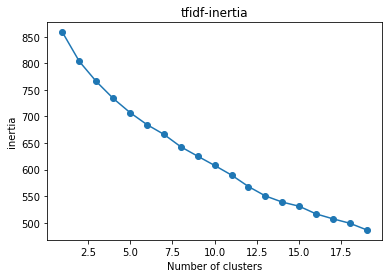

In [130]:
plt.plot(x, y, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('inertia')
plt.title("tfidf-inertia")
plt.show()